In [1]:
!pip install tensorflow==2.15.0 scikit-learn pandas numpy matplotlib seaborn


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("ENVIRONMENT SETUP")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"GPU Device: {tf.config.list_physical_devices('GPU')}")
print("="*80)

ENVIRONMENT SETUP
TensorFlow version: 2.19.0
GPU Available: False
GPU Device: []


In [4]:
print("\n📁 Upload your combined_economic_data.csv file")
print("="*80)

uploaded = files.upload()

# Save uploaded file to /content/
for filename in uploaded.keys():
    print(f"✓ Uploaded: {filename}")

# Load the dataset
df = pd.read_csv('/content/combined_economic_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n✓ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Months: {len(df)}")


📁 Upload your combined_economic_data.csv file


Saving combined_economic_data.csv to combined_economic_data (1).csv
✓ Uploaded: combined_economic_data (1).csv

✓ Dataset loaded successfully!
Shape: (300, 8)
Date Range: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Total Months: 300


In [5]:
print("\n" + "="*80)
print("PHASE 1: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Display first few rows
print("\n1. Dataset Preview:")
print(df.head(10))

# Basic statistics
print("\n2. Descriptive Statistics:")
print(df.describe())

# Missing values check
print("\n3. Missing Values:")
print(df.isnull().sum())

# Define feature columns
numeric_cols = ['WTI_Price_USD', 'Inflation_YoY (%)', 'M2 (Billions USD)',
                'Fed_Funds_Rate (%)', 'Unemployment_rate (%)',
                'PPI_All_Commodities (Index 1982=100)']

print(f"\n4. Features for Modeling: {len(numeric_cols)}")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i}. {col}")


PHASE 1: EXPLORATORY DATA ANALYSIS

1. Dataset Preview:
        Date  WTI_Price_USD  CPI_Index  Inflation_YoY (%)  M2 (Billions USD)  \
0 2000-01-01          90.15    170.000               3.74            4800.00   
1 2000-02-01          99.75    170.425               3.74            4812.93   
2 2000-03-01         110.23    171.243               3.74            4860.93   
3 2000-04-01         122.33    171.916               3.74            4877.79   
4 2000-05-01         133.07    172.499               3.74            4894.68   
5 2000-06-01         141.22    172.780               3.74            4928.49   
6 2000-07-01         150.00    173.060               3.74            4965.56   
7 2000-08-01         149.94    173.273               3.74            5002.21   
8 2000-09-01         150.00    174.047               3.74            5012.25   
9 2000-10-01         146.29    174.640               3.74            5065.64   

   PPI_All_Commodities (Index 1982=100)  Fed_Funds_Rate (%)  \


CORRELATION ANALYSIS

Correlation Matrix:
                                      WTI_Price_USD  Inflation_YoY (%)  \
WTI_Price_USD                                 1.000              0.099   
Inflation_YoY (%)                             0.099              1.000   
M2 (Billions USD)                            -0.088              0.334   
Fed_Funds_Rate (%)                           -0.001              0.114   
Unemployment_rate (%)                        -0.010              0.005   
PPI_All_Commodities (Index 1982=100)         -0.083              0.328   

                                      M2 (Billions USD)  Fed_Funds_Rate (%)  \
WTI_Price_USD                                    -0.088              -0.001   
Inflation_YoY (%)                                 0.334               0.114   
M2 (Billions USD)                                 1.000              -0.163   
Fed_Funds_Rate (%)                               -0.163               1.000   
Unemployment_rate (%)                      

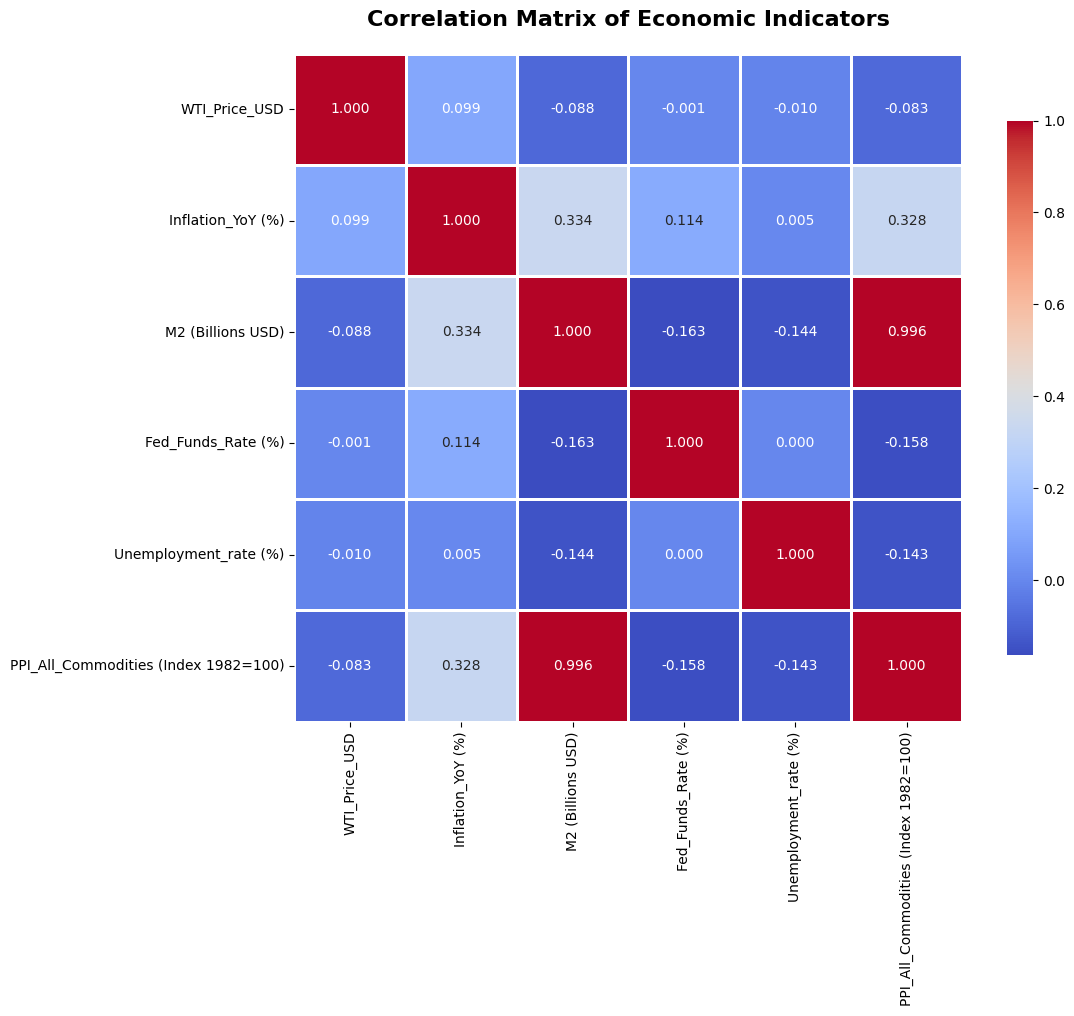

✓ Correlation matrix saved to /content/correlation_matrix.png


In [6]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Correlation matrix
correlation_matrix = df[numeric_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Economic Indicators', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/content/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Correlation matrix saved to /content/correlation_matrix.png")


TIME SERIES VISUALIZATION


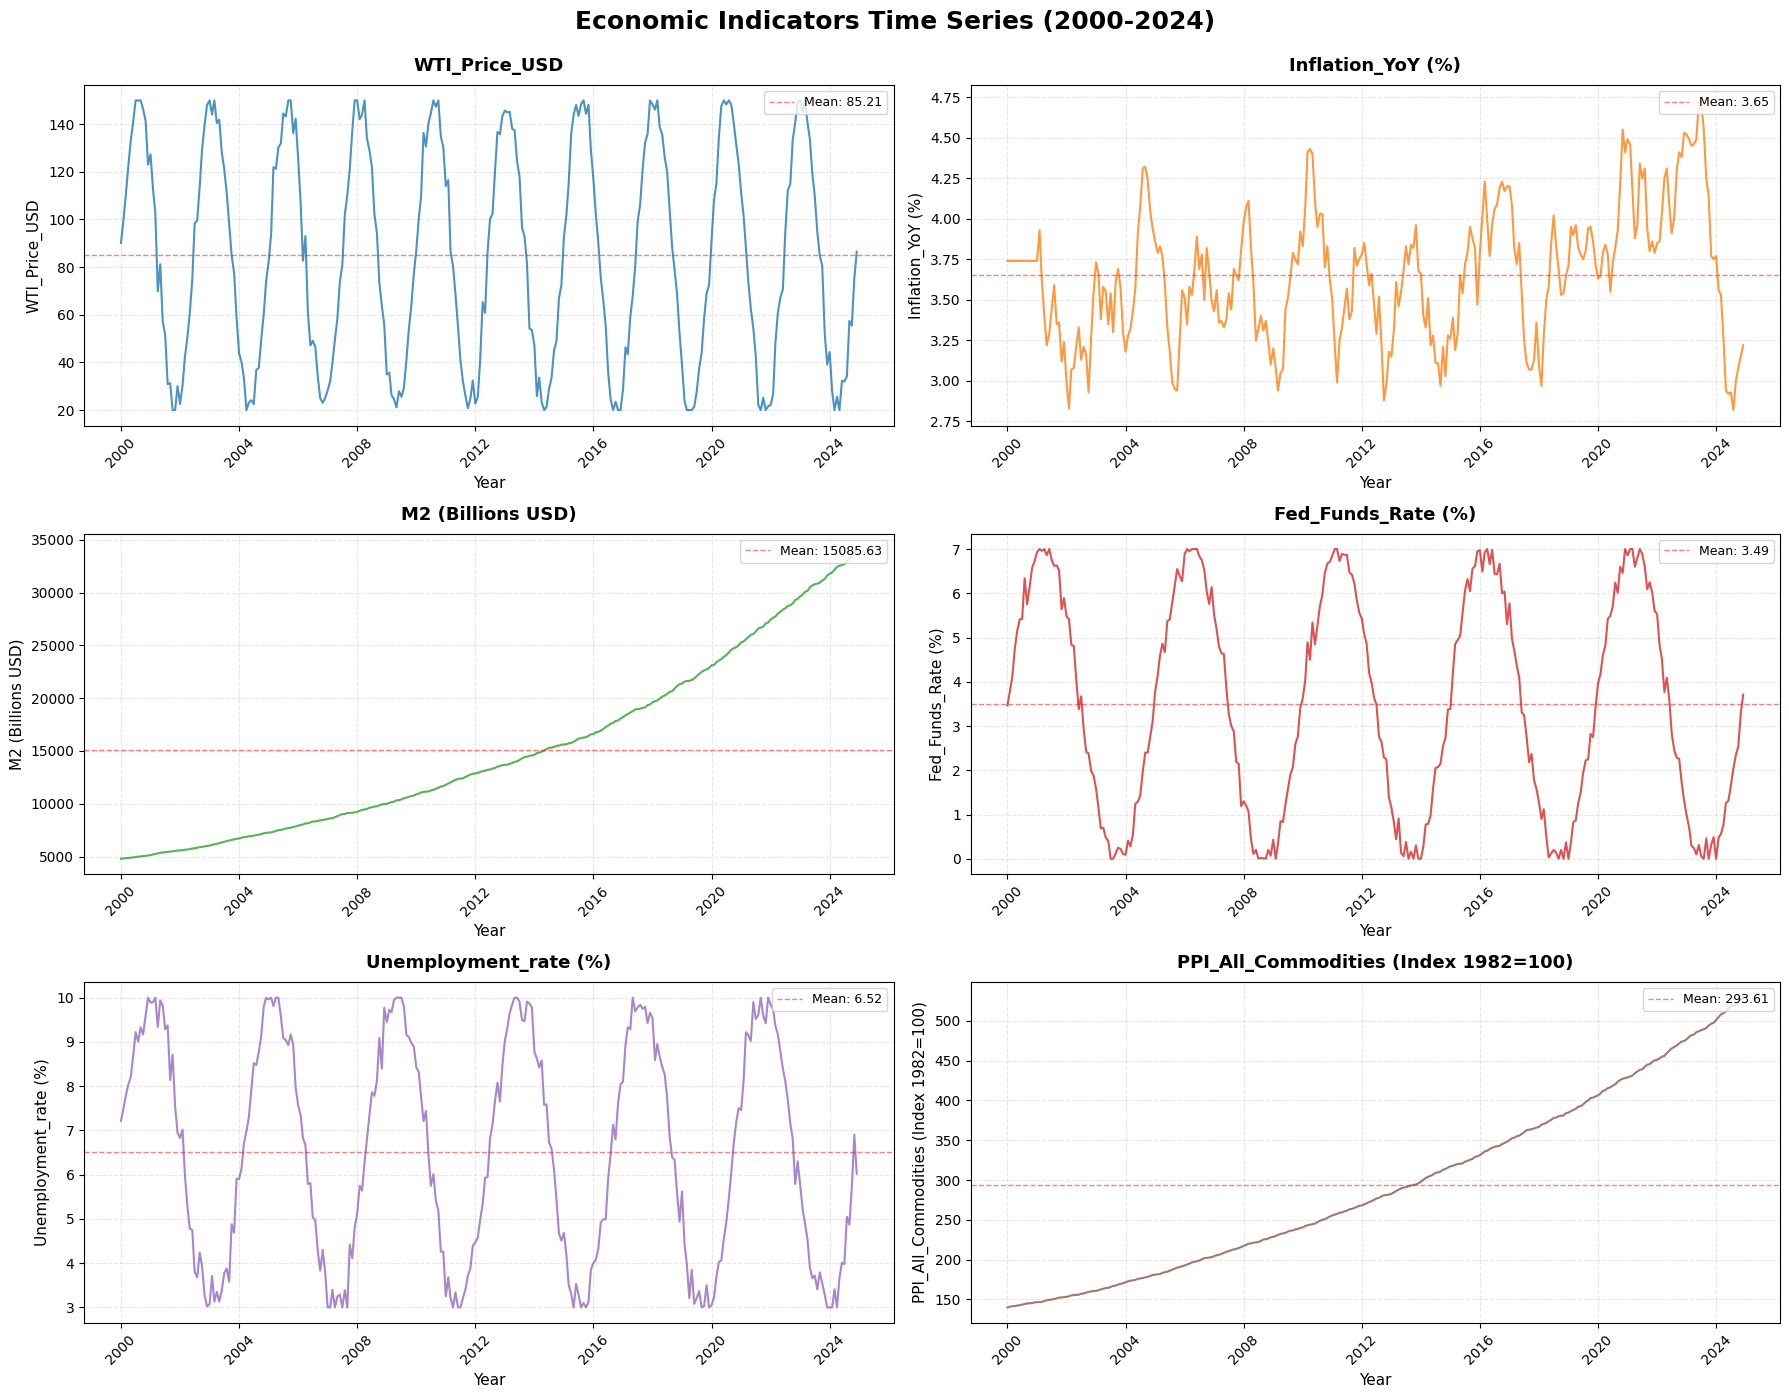

✓ Time series plots saved to /content/time_series_plots.png


In [7]:
print("\n" + "="*80)
print("TIME SERIES VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Economic Indicators Time Series (2000-2024)', fontsize=18, fontweight='bold', y=0.995)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_idx = idx % 2

    axes[row, col_idx].plot(df['Date'], df[col], linewidth=1.5, color=colors[idx], alpha=0.8)
    axes[row, col_idx].set_title(col, fontsize=13, fontweight='bold', pad=10)
    axes[row, col_idx].set_xlabel('Year', fontsize=11)
    axes[row, col_idx].set_ylabel(col, fontsize=11)
    axes[row, col_idx].grid(True, alpha=0.3, linestyle='--')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

    # Add mean line
    mean_val = df[col].mean()
    axes[row, col_idx].axhline(y=mean_val, color='red', linestyle='--',
                               linewidth=1, alpha=0.5, label=f'Mean: {mean_val:.2f}')
    axes[row, col_idx].legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('/content/time_series_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Time series plots saved to /content/time_series_plots.png")

In [8]:
print("\n" + "="*80)
print("KEY ECONOMIC PERIODS ANALYSIS")
print("="*80)

df['Year'] = df['Date'].dt.year

# Financial Crisis
financial_crisis = df[(df['Year'] >= 2007) & (df['Year'] <= 2009)]
print("\n📊 2008 Financial Crisis (2007-2009):")
print(f"   Average Oil Price: ${financial_crisis['WTI_Price_USD'].mean():.2f}")
print(f"   Average Inflation: {financial_crisis['Inflation_YoY (%)'].mean():.2f}%")
print(f"   Average Unemployment: {financial_crisis['Unemployment_rate (%)'].mean():.2f}%")
print(f"   Average Fed Rate: {financial_crisis['Fed_Funds_Rate (%)'].mean():.2f}%")

# COVID Period
covid_period = df[(df['Year'] >= 2020) & (df['Year'] <= 2021)]
print("\n🦠 COVID-19 Period (2020-2021):")
print(f"   Average Oil Price: ${covid_period['WTI_Price_USD'].mean():.2f}")
print(f"   Average Inflation: {covid_period['Inflation_YoY (%)'].mean():.2f}%")
print(f"   Average Unemployment: {covid_period['Unemployment_rate (%)'].mean():.2f}%")
print(f"   Average Fed Rate: {covid_period['Fed_Funds_Rate (%)'].mean():.2f}%")

# Recent Inflation Surge
inflation_surge = df[(df['Year'] >= 2022) & (df['Year'] <= 2024)]
print("\n📈 Recent Inflation Surge (2022-2024):")
print(f"   Average Oil Price: ${inflation_surge['WTI_Price_USD'].mean():.2f}")
print(f"   Average Inflation: {inflation_surge['Inflation_YoY (%)'].mean():.2f}%")
print(f"   Average Unemployment: {inflation_surge['Unemployment_rate (%)'].mean():.2f}%")
print(f"   Average Fed Rate: {inflation_surge['Fed_Funds_Rate (%)'].mean():.2f}%")


KEY ECONOMIC PERIODS ANALYSIS

📊 2008 Financial Crisis (2007-2009):
   Average Oil Price: $77.94
   Average Inflation: 3.50%
   Average Unemployment: 6.79%
   Average Fed Rate: 1.83%

🦠 COVID-19 Period (2020-2021):
   Average Oil Price: $92.99
   Average Inflation: 4.01%
   Average Unemployment: 7.14%
   Average Fed Rate: 6.05%

📈 Recent Inflation Surge (2022-2024):
   Average Oil Price: $79.23
   Average Inflation: 3.90%
   Average Unemployment: 5.52%
   Average Fed Rate: 1.75%


In [9]:
print("\n" + "="*80)
print("PHASE 2: DATA PREPROCESSING")
print("="*80)

# Select core features
core_features = ['WTI_Price_USD', 'Inflation_YoY (%)', 'M2 (Billions USD)',
                 'Fed_Funds_Rate (%)', 'Unemployment_rate (%)',
                 'PPI_All_Commodities (Index 1982=100)']

df_clean = df[['Date'] + core_features].copy()
df_clean = df_clean.dropna().reset_index(drop=True)

print(f"\n1. Data Cleaning:")
print(f"   Original rows: {len(df)}")
print(f"   Cleaned rows: {len(df_clean)}")
print(f"   Removed rows: {len(df) - len(df_clean)}")

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[core_features])

print(f"\n2. Data Normalization:")
print(f"   Method: StandardScaler (zero mean, unit variance)")
print(f"   Features scaled: {len(core_features)}")

# Display scaling parameters
print(f"\n3. Scaling Parameters:")
for i, feature in enumerate(core_features):
    print(f"   {feature}:")
    print(f"      Mean: {scaler.mean_[i]:.2f}")
    print(f"      Std: {scaler.scale_[i]:.2f}")


PHASE 2: DATA PREPROCESSING

1. Data Cleaning:
   Original rows: 300
   Cleaned rows: 300
   Removed rows: 0

2. Data Normalization:
   Method: StandardScaler (zero mean, unit variance)
   Features scaled: 6

3. Scaling Parameters:
   WTI_Price_USD:
      Mean: 85.21
      Std: 45.48
   Inflation_YoY (%):
      Mean: 3.65
      Std: 0.40
   M2 (Billions USD):
      Mean: 15085.63
      Std: 8201.56
   Fed_Funds_Rate (%):
      Mean: 3.49
      Std: 2.47
   Unemployment_rate (%):
      Mean: 6.52
      Std: 2.45
   PPI_All_Commodities (Index 1982=100):
      Mean: 293.61
      Std: 111.23


In [10]:
print("\n" + "="*80)
print("PHASE 3: SEQUENCE CREATION FOR LSTM")
print("="*80)

def create_sequences(data, target_col_idx, n_steps=12):
    """
    Create sequences for LSTM training

    Args:
        data: Normalized data array
        target_col_idx: Index of target variable
        n_steps: Lookback period (default: 12 months)

    Returns:
        X: Input sequences (samples, timesteps, features)
        y: Target values (samples,)
    """
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])  # All features for past n_steps
        y.append(data[i, target_col_idx])  # Target variable at time i
    return np.array(X), np.array(y)

# Configuration
n_lookback = 12  # 12-month lookback window
target_inflation_idx = core_features.index('Inflation_YoY (%)')
target_oil_idx = core_features.index('WTI_Price_USD')

print(f"\n1. Sequence Configuration:")
print(f"   Lookback Period: {n_lookback} months")
print(f"   Target Variable (Inflation): {core_features[target_inflation_idx]}")
print(f"   Target Variable (Oil): {core_features[target_oil_idx]}")

# Create sequences for both targets
X_inflation, y_inflation = create_sequences(scaled_data, target_inflation_idx, n_lookback)
X_oil, y_oil = create_sequences(scaled_data, target_oil_idx, n_lookback)

print(f"\n2. Sequence Generation:")
print(f"   Inflation Sequences:")
print(f"      X shape: {X_inflation.shape} (samples, timesteps, features)")
print(f"      y shape: {y_inflation.shape} (samples,)")
print(f"   Oil Price Sequences:")
print(f"      X shape: {X_oil.shape}")
print(f"      y shape: {y_oil.shape}")

# Train-test split (80-20)
train_size = int(len(X_inflation) * 0.8)
test_size = len(X_inflation) - train_size

X_train_inf, X_test_inf = X_inflation[:train_size], X_inflation[train_size:]
y_train_inf, y_test_inf = y_inflation[:train_size], y_inflation[train_size:]

X_train_oil, X_test_oil = X_oil[:train_size], X_oil[train_size:]
y_train_oil, y_test_oil = y_oil[:train_size], y_oil[train_size:]

print(f"\n3. Train-Test Split (80-20):")
print(f"   Training samples: {train_size} ({train_size/len(X_inflation)*100:.1f}%)")
print(f"   Testing samples: {test_size} ({test_size/len(X_inflation)*100:.1f}%)")
print(f"\n   Inflation Model:")
print(f"      X_train: {X_train_inf.shape}")
print(f"      X_test: {X_test_inf.shape}")
print(f"      y_train: {y_train_inf.shape}")
print(f"      y_test: {y_test_inf.shape}")


PHASE 3: SEQUENCE CREATION FOR LSTM

1. Sequence Configuration:
   Lookback Period: 12 months
   Target Variable (Inflation): Inflation_YoY (%)
   Target Variable (Oil): WTI_Price_USD

2. Sequence Generation:
   Inflation Sequences:
      X shape: (288, 12, 6) (samples, timesteps, features)
      y shape: (288,) (samples,)
   Oil Price Sequences:
      X shape: (288, 12, 6)
      y shape: (288,)

3. Train-Test Split (80-20):
   Training samples: 230 (79.9%)
   Testing samples: 58 (20.1%)

   Inflation Model:
      X_train: (230, 12, 6)
      X_test: (58, 12, 6)
      y_train: (230,)
      y_test: (58,)


In [11]:
print("\n" + "="*80)
print("PHASE 4: MODEL ARCHITECTURES")
print("="*80)

# Custom Attention Layer
class AttentionLayer(layers.Layer):
    """Custom Attention Mechanism for LSTM"""

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Attention mechanism
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

# Model 1: Vanilla LSTM
def create_vanilla_lstm(n_steps=12, n_features=6):
    """Simple LSTM baseline model"""

    model = models.Sequential([
        layers.LSTM(64, activation='relu', return_sequences=True,
                   input_shape=(n_steps, n_features), name='lstm_1'),
        layers.Dropout(0.2, name='dropout_1'),
        layers.LSTM(32, activation='relu', name='lstm_2'),
        layers.Dropout(0.2, name='dropout_2'),
        layers.Dense(16, activation='relu', name='dense_1'),
        layers.Dense(1, name='output')
    ], name='Vanilla_LSTM')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Model 2: BiLSTM with Attention
def create_bilstm_attention(n_steps=12, n_features=6):
    """Bidirectional LSTM with Attention Mechanism"""

    inputs = layers.Input(shape=(n_steps, n_features), name='input')

    # Bidirectional LSTM layers
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True),
        name='bidirectional_lstm_1'
    )(inputs)
    x = layers.Dropout(0.3, name='dropout_1')(x)

    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True),
        name='bidirectional_lstm_2'
    )(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # Attention mechanism
    x = AttentionLayer(name='attention')(x)

    # Dense layers
    x = layers.Dense(32, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.2, name='dropout_3')(x)
    outputs = layers.Dense(1, name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='BiLSTM_Attention')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Model 3: CNN-LSTM Hybrid
def create_cnn_lstm(n_steps=12, n_features=6):
    """CNN-LSTM for pattern extraction and temporal modeling"""

    inputs = layers.Input(shape=(n_steps, n_features), name='input')

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     padding='same', name='conv1d_1')(inputs)
    x = layers.MaxPooling1D(pool_size=2, name='maxpool_1')(x)
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                     padding='same', name='conv1d_2')(x)
    x = layers.MaxPooling1D(pool_size=2, name='maxpool_2')(x)

    # LSTM layers
    x = layers.LSTM(100, return_sequences=True, name='lstm_1')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)
    x = layers.LSTM(50, name='lstm_2')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # Dense layers
    x = layers.Dense(25, activation='relu', name='dense_1')(x)
    outputs = layers.Dense(1, name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='CNN_LSTM')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Model 4: Transformer Model
def create_transformer_model(n_steps=12, n_features=6, head_size=256, num_heads=4):
    """Transformer with multi-head attention"""

    inputs = layers.Input(shape=(n_steps, n_features), name='input')
    x = inputs

    # Transformer blocks
    for i in range(2):
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=head_size,
            dropout=0.25,
            name=f'multi_head_attention_{i+1}'
        )(x, x)

        # Add & Norm
        x1 = layers.Add(name=f'add_1_{i+1}')([x, attention_output])
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f'layer_norm_1_{i+1}')(x1)

        # Feed Forward Network
        ffn = layers.Dense(4, activation="relu", name=f'ffn_dense_1_{i+1}')(x1)
        ffn = layers.Dropout(0.25, name=f'ffn_dropout_{i+1}')(ffn)
        ffn = layers.Dense(n_features, name=f'ffn_dense_2_{i+1}')(ffn)

        # Add & Norm
        x = layers.Add(name=f'add_2_{i+1}')([x1, ffn])
        x = layers.LayerNormalization(epsilon=1e-6, name=f'layer_norm_2_{i+1}')(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)

    # MLP head
    x = layers.Dense(128, activation="relu", name='mlp_dense')(x)
    x = layers.Dropout(0.25, name='mlp_dropout')(x)
    outputs = layers.Dense(1, name='output')(x)

    model = models.Model(inputs, outputs, name='Transformer')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

print("✓ Model architectures defined:")
print("   1. Vanilla LSTM")
print("   2. BiLSTM with Attention")
print("   3. CNN-LSTM Hybrid")
print("   4. Transformer Model")



PHASE 4: MODEL ARCHITECTURES
✓ Model architectures defined:
   1. Vanilla LSTM
   2. BiLSTM with Attention
   3. CNN-LSTM Hybrid
   4. Transformer Model


In [12]:
def train_model(model, X_train, y_train, X_test, y_test, model_name, epochs=100, batch_size=32):
    """
    Train model with callbacks

    Args:
        model: Keras model
        X_train, y_train: Training data
        X_test, y_test: Testing data
        model_name: Name for saving
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        history: Training history
    """

    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")

    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Save model to /content/
    model_path = f'/content/{model_name}_best.keras'
    model.save(model_path)
    print(f"\n✓ Model saved: {model_path}")

    # Plot training history
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    plt.title(f'{model_name} - MAE', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'/content/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    return history


In [13]:
def inverse_transform_target(y_scaled, scaler, target_idx):
    """Inverse transform target variable"""
    n_features = len(scaler.mean_)
    y_full = np.zeros((len(y_scaled), n_features))
    y_full[:, target_idx] = y_scaled
    y_inverse = scaler.inverse_transform(y_full)
    return y_inverse[:, target_idx]

def evaluate_model(model, X_test, y_test, scaler, target_idx, model_name, target_name):
    """
    Evaluate model performance

    Args:
        model: Trained model
        X_test, y_test: Test data
        scaler: Fitted scaler
        target_idx: Index of target variable
        model_name: Model name
        target_name: Target variable name

    Returns:
        metrics: Dictionary of metrics
    """

    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}")

    # Predictions
    y_pred_scaled = model.predict(X_test, verbose=0).flatten()

    # Inverse transform
    y_test_original = inverse_transform_target(y_test, scaler, target_idx)
    y_pred_original = inverse_transform_target(y_pred_scaled, scaler, target_idx)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    r2 = r2_score(y_test_original, y_pred_original)

    # Directional accuracy
    if len(y_test_original) > 1:
        y_test_direction = np.diff(y_test_original) > 0
        y_pred_direction = np.diff(y_pred_original) > 0
        directional_accuracy = np.mean(y_test_direction == y_pred_direction) * 100
    else:
        directional_accuracy = 0.0

    # Display metrics
    print(f"\n📊 Performance Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²: {r2:.4f}")
    print(f"   Directional Accuracy: {directional_accuracy:.2f}%")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Time series plot
    axes[0].plot(y_test_original, label='Actual', marker='o', markersize=5, linewidth=2, alpha=0.7)
    axes[0].plot(y_pred_original, label='Predicted', marker='s', markersize=5, linewidth=2, alpha=0.7)
    axes[0].set_title(f'{model_name} - {target_name} Predictions', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Test Sample', fontsize=12)
    axes[0].set_ylabel(target_name, fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Scatter plot
    axes[1].scatter(y_test_original, y_pred_original, alpha=0.6, s=50)
    axes[1].plot([y_test_original.min(), y_test_original.max()],
                [y_test_original.min(), y_test_original.max()],
                'r--', lw=2, label='Perfect Prediction')
    axes[1].set_title(f'{model_name} - Actual vs Predicted', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(f'Actual {target_name}', fontsize=12)
    axes[1].set_ylabel(f'Predicted {target_name}', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'/content/{model_name}_{target_name}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Directional_Accuracy': directional_accuracy
    }

    return metrics, y_pred_original, y_test_original


PHASE 5: TRAINING INFLATION FORECASTING MODELS

🚀 Training Model 1/4: Vanilla LSTM

Model Architecture:


Model: "Vanilla_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)


Training vanilla_lstm_inflation
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 0.8440 - mae: 0.7596 - val_loss: 2.1536 - val_mae: 1.2756 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7792 - mae: 0.7362 - val_loss: 2.2967 - val_mae: 1.3273 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7182 - mae: 0.7030 - val_loss: 2.4411 - val_mae: 1.3722 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6539 - mae: 0.6685 - val_loss: 3.0869 - val_mae: 1.5189 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5991 - mae: 0.6260 - val_loss: 6.6675 - val_mae: 1.9639 - learning_rate: 0.0010
Epoch 6/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5786 - mae: 0.6168
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5464 - mae: 0.5962 - val_loss: 11.6816 - val_mae: 2.3042 - lea

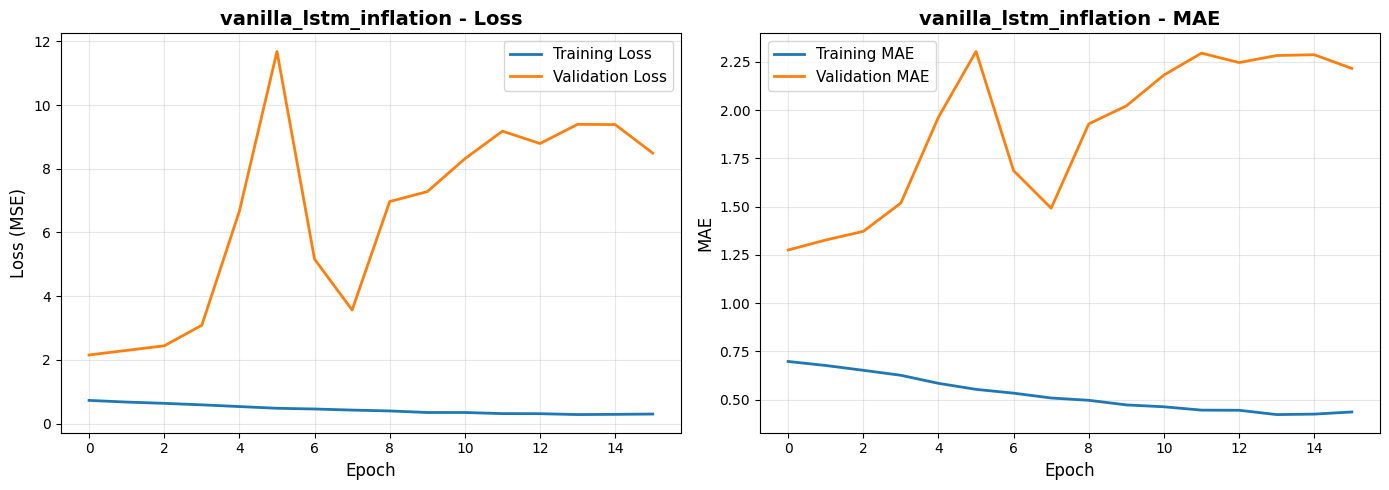


Evaluating Vanilla_LSTM

📊 Performance Metrics:
   RMSE: 0.5896
   MAE: 0.5125
   MAPE: 12.81%
   R²: -0.4059
   Directional Accuracy: 38.60%


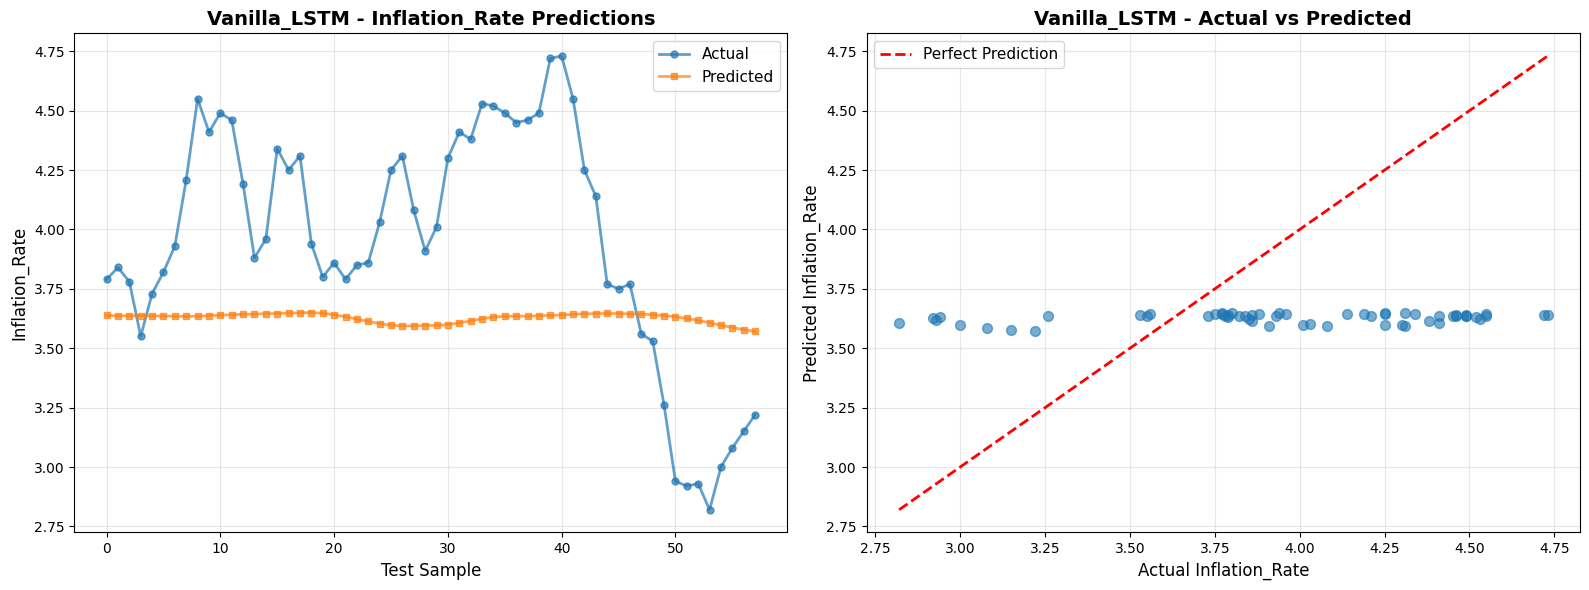


🚀 Training Model 2/4: BiLSTM with Attention

Model Architecture:


Model: "BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 12, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 12, 256)        │       138,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 12, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,265 (1.23 MB)

 Trainable params: 323,265 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


Training bilstm_attention_inflation
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.8323 - mae: 0.7443 - val_loss: 1.8082 - val_mae: 1.1490 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.5574 - mae: 0.6024 - val_loss: 1.7406 - val_mae: 1.1238 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.3473 - mae: 0.4859 - val_loss: 1.6231 - val_mae: 1.0741 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.2805 - mae: 0.4375 - val_loss: 1.2377 - val_mae: 0.9434 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.2211 - mae: 0.3801 - val_loss: 0.9942 - val_mae: 0.8554 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2046 - mae: 0.3495 - val_loss: 0.9937 - val_mae: 0.8498 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2121 - mae: 0.3713 - val_loss: 0.9956 - val_mae: 0.8518 - l

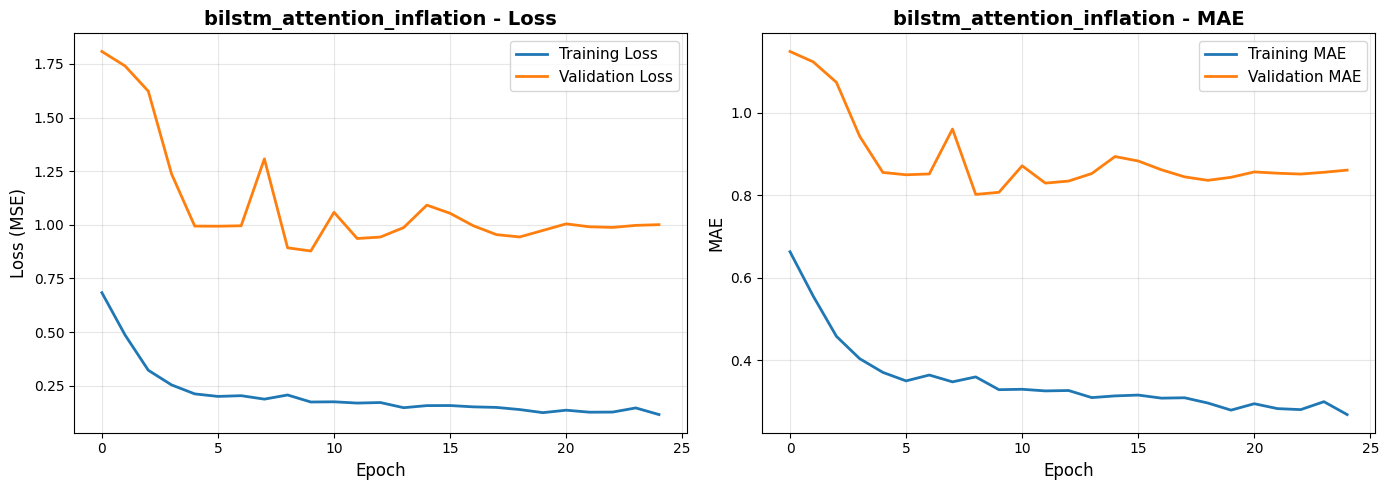


Evaluating BiLSTM_Attention

📊 Performance Metrics:
   RMSE: 0.3765
   MAE: 0.3243
   MAPE: 8.47%
   R²: 0.4268
   Directional Accuracy: 50.88%


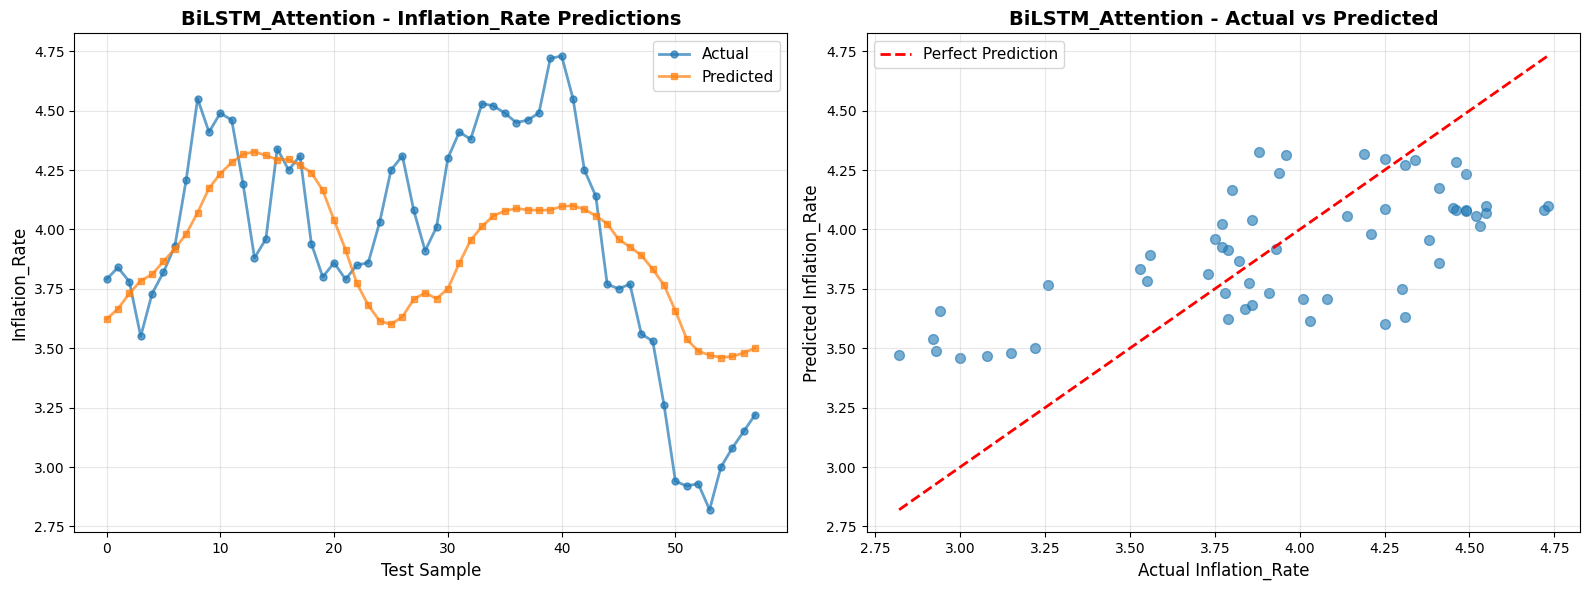


🚀 Training Model 3/4: CNN-LSTM Hybrid

Model Architecture:


Model: "CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 12, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 100)         │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,021 (582.11 KB)

 Trainable params: 149,021 (582.11 KB)

 Non-trainable params: 0 (0.00 B)


Training cnn_lstm_inflation
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.8208 - mae: 0.7501 - val_loss: 2.1200 - val_mae: 1.2653 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7355 - mae: 0.7127 - val_loss: 2.0882 - val_mae: 1.2533 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6492 - mae: 0.6659 - val_loss: 2.0620 - val_mae: 1.2382 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5525 - mae: 0.6094 - val_loss: 2.2260 - val_mae: 1.2956 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3975 - mae: 0.5079 - val_loss: 2.1866 - val_mae: 1.2578 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3200 - mae: 0.4427 - val_loss: 2.0164 - val_mae: 1.1787 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2710 - mae: 0.4095 - val_loss: 1.7295 - val_mae: 1.0890 - learning_rate

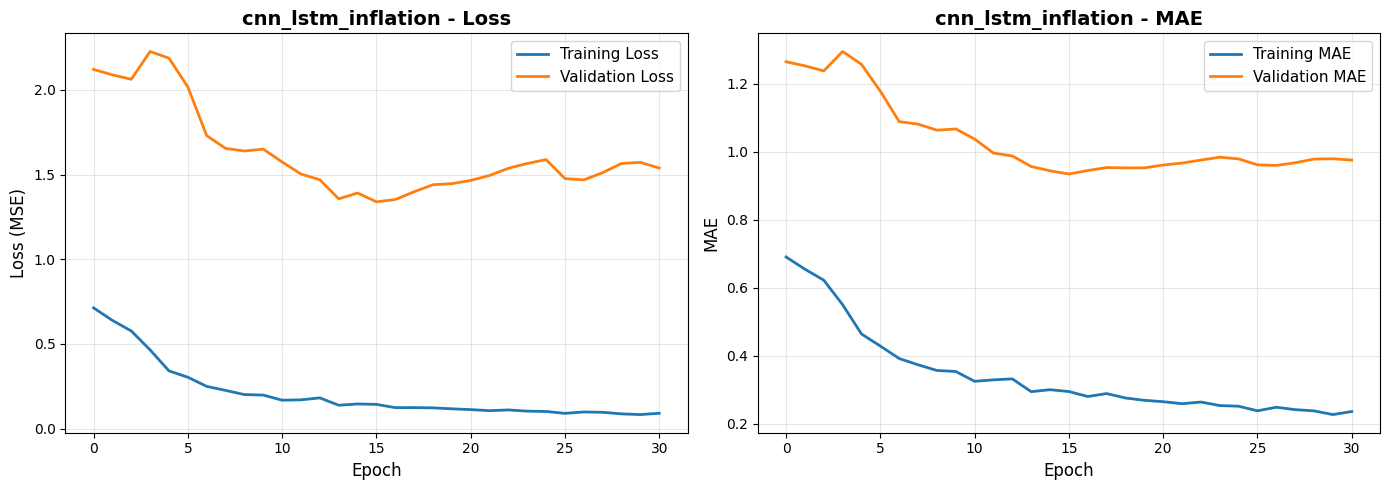


Evaluating CNN_LSTM



📊 Performance Metrics:
   RMSE: 0.4648
   MAE: 0.3755
   MAPE: 10.28%
   R²: 0.1260
   Directional Accuracy: 54.39%


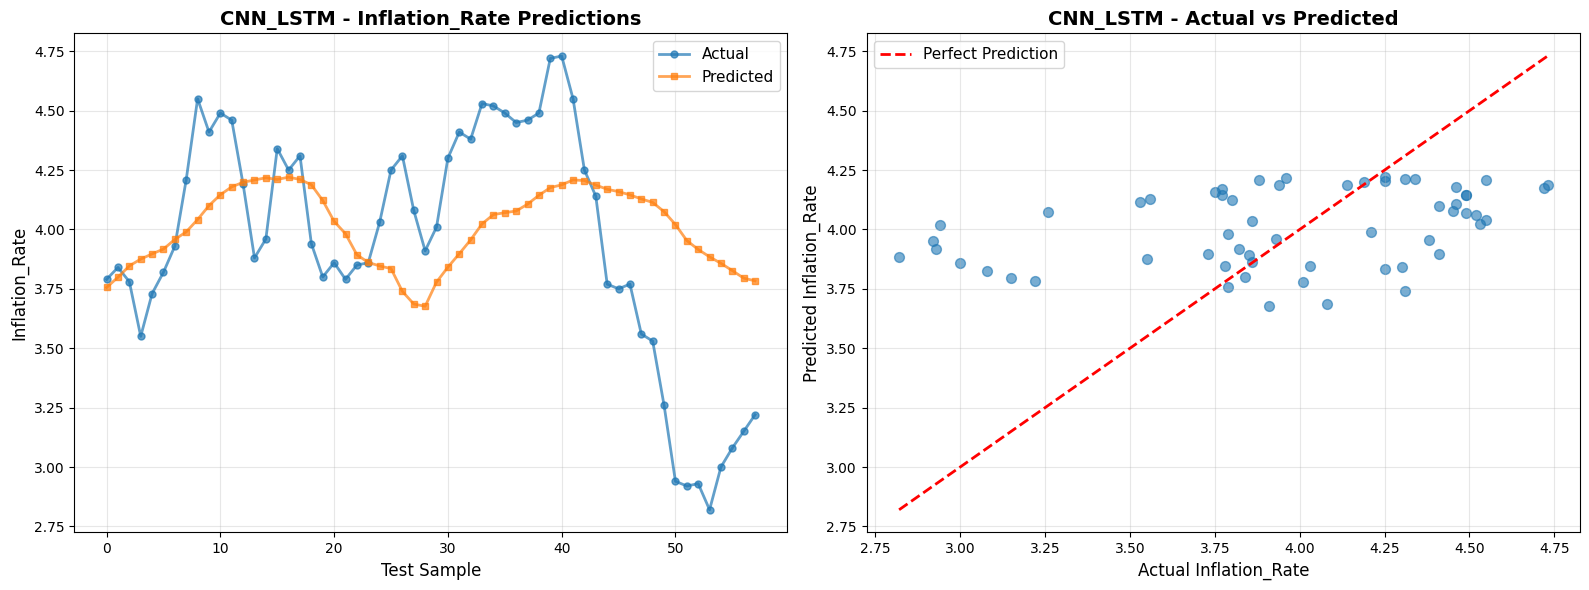


🚀 Training Model 4/4: Transformer

Model Architecture:


Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 12, 6)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 6)     │     27,654 │ input[0][0],      │
│ (MultiHeadAttentio… │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1_1 (Add)       │ (None, 12, 6)     │          0 │ input[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1_1      │ (None, 12, 6)     │         12 │ add_1_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1_1       │ (None, 12, 4)     │         28 │ layer_norm_1_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dropout_1       │ (None, 12, 4)     │          0 │ ffn_dense_1_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2_1       │ (None, 12, 6)     │         30 │ ffn_dropout_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2_1 (Add)       │ (None, 12, 6)     │          0 │ layer_norm_1_1[0… │
│                     │                   │            │ ffn_dense_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2_1      │ (None, 12, 6)     │         12 │ add_2_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 6)     │     27,654 │ layer_norm_2_1[0… │
│ (MultiHeadAttentio… │                   │            │ layer_norm_2_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1_2 (Add)       │ (None, 12, 6)     │          0 │ layer_norm_2_1[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1_2      │ (None, 12, 6)     │         12 │ add_1_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1_2       │ (None, 12, 4)     │         28 │ layer_norm_1_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dropout_2       │ (None, 12, 4)     │          0 │ ffn_dense_1_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2_2       │ (None, 12, 6)     │         30 │ ffn_dropout_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2_2 (Add)       │ (None, 12, 6)     │          0 │ layer_norm_1_2[0… │
│                     │                   │            │ ffn_dense_2_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2_2      │ (None, 12, 6)     │         12 │ add_2_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 56,497 (220.69 KB)

 Trainable params: 56,497 (220.69 KB)

 Non-trainable params: 0 (0.00 B)


Training transformer_inflation
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 0.9530 - mae: 0.7936 - val_loss: 2.1299 - val_mae: 1.2574 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.8337 - mae: 0.7468 - val_loss: 2.4961 - val_mae: 1.3643 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7660 - mae: 0.7228 - val_loss: 2.3474 - val_mae: 1.3165 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.6831 - mae: 0.6815 - val_loss: 2.1360 - val_mae: 1.2428 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.6549 - mae: 0.6575 - val_loss: 2.1094 - val_mae: 1.2126 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.6047 - mae: 0.6251 - val_loss: 2.2712 - val_mae: 1.2817 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6079 - mae: 0.6244 - val_loss: 2.3743 - val_mae: 1.3236 - learning

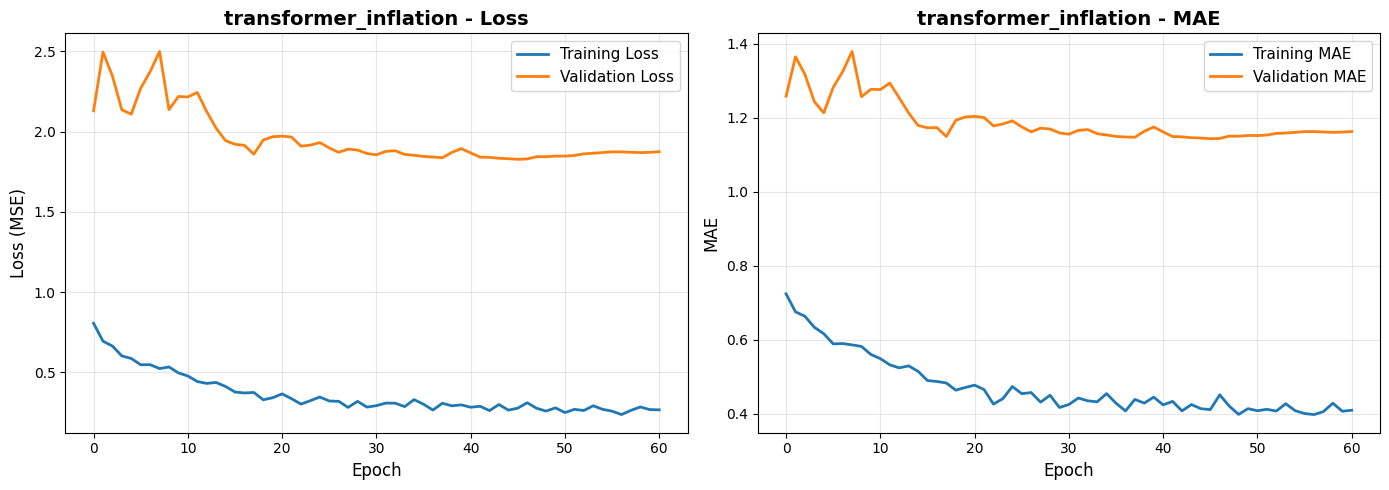


Evaluating Transformer

📊 Performance Metrics:
   RMSE: 0.5431
   MAE: 0.4591
   MAPE: 12.11%
   R²: -0.1932
   Directional Accuracy: 36.84%


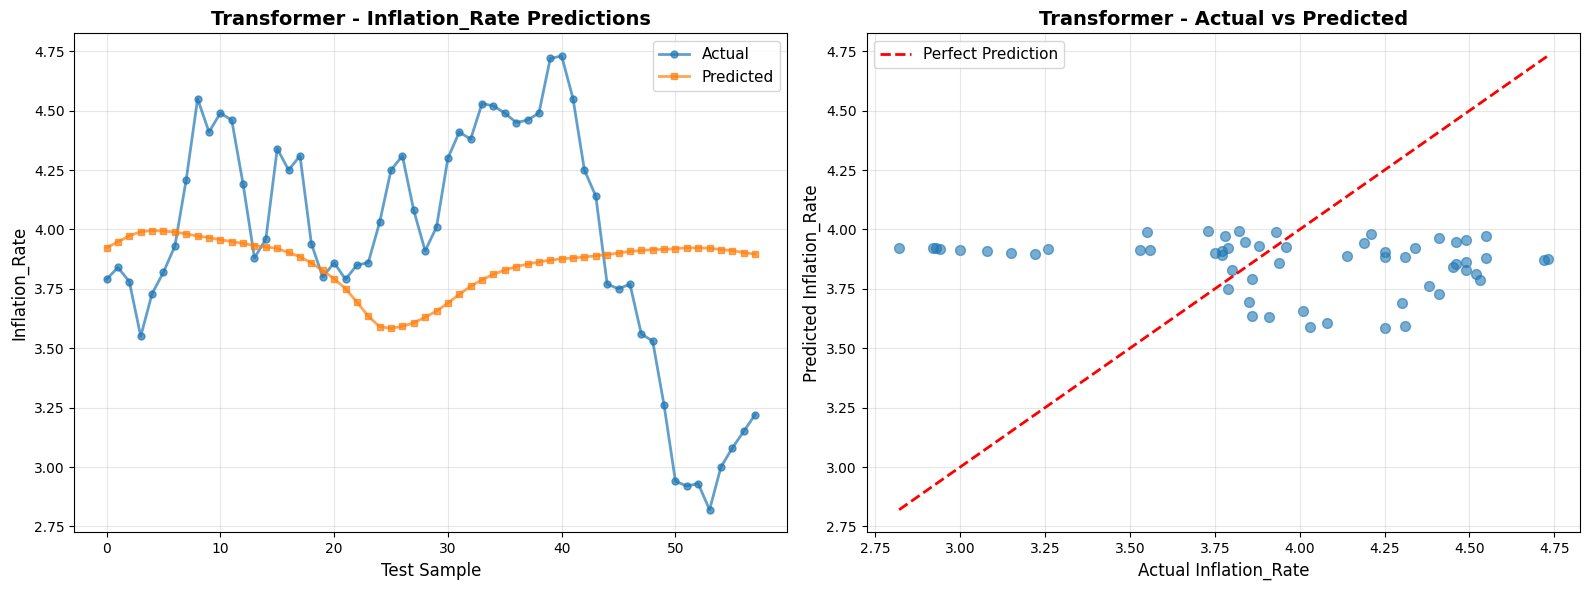

In [14]:
print("\n" + "="*80)
print("PHASE 5: TRAINING INFLATION FORECASTING MODELS")
print("="*80)

results_inflation = {}

# Model 1: Vanilla LSTM
print("\n🚀 Training Model 1/4: Vanilla LSTM")
model1 = create_vanilla_lstm(n_steps=n_lookback, n_features=len(core_features))
print(f"\nModel Architecture:")
model1.summary()

history1 = train_model(
    model1, X_train_inf, y_train_inf, X_test_inf, y_test_inf,
    'vanilla_lstm_inflation', epochs=100, batch_size=32
)

metrics1, pred1, actual1 = evaluate_model(
    model1, X_test_inf, y_test_inf, scaler, target_inflation_idx,
    'Vanilla_LSTM', 'Inflation_Rate'
)
results_inflation['Vanilla LSTM'] = metrics1

# Model 2: BiLSTM with Attention
print("\n🚀 Training Model 2/4: BiLSTM with Attention")
model2 = create_bilstm_attention(n_steps=n_lookback, n_features=len(core_features))
print(f"\nModel Architecture:")
model2.summary()

history2 = train_model(
    model2, X_train_inf, y_train_inf, X_test_inf, y_test_inf,
    'bilstm_attention_inflation', epochs=100, batch_size=32
)

metrics2, pred2, actual2 = evaluate_model(
    model2, X_test_inf, y_test_inf, scaler, target_inflation_idx,
    'BiLSTM_Attention', 'Inflation_Rate'
)
results_inflation['BiLSTM Attention'] = metrics2

# Model 3: CNN-LSTM
print("\n🚀 Training Model 3/4: CNN-LSTM Hybrid")
model3 = create_cnn_lstm(n_steps=n_lookback, n_features=len(core_features))
print(f"\nModel Architecture:")
model3.summary()

history3 = train_model(
    model3, X_train_inf, y_train_inf, X_test_inf, y_test_inf,
    'cnn_lstm_inflation', epochs=100, batch_size=32
)

metrics3, pred3, actual3 = evaluate_model(
    model3, X_test_inf, y_test_inf, scaler, target_inflation_idx,
    'CNN_LSTM', 'Inflation_Rate'
)
results_inflation['CNN-LSTM'] = metrics3

# Model 4: Transformer
print("\n🚀 Training Model 4/4: Transformer")
model4 = create_transformer_model(n_steps=n_lookback, n_features=len(core_features))
print(f"\nModel Architecture:")
model4.summary()

history4 = train_model(
    model4, X_train_inf, y_train_inf, X_test_inf, y_test_inf,
    'transformer_inflation', epochs=100, batch_size=32
)

metrics4, pred4, actual4 = evaluate_model(
    model4, X_test_inf, y_test_inf, scaler, target_inflation_idx,
    'Transformer', 'Inflation_Rate'
)
results_inflation['Transformer'] = metrics4



FINAL RESULTS: INFLATION FORECASTING

📊 Performance Comparison:
                    RMSE     MAE     MAPE      R²  Directional_Accuracy
Vanilla LSTM      0.5896  0.5125  12.8090 -0.4059               38.5965
BiLSTM Attention  0.3765  0.3243   8.4657  0.4268               50.8772
CNN-LSTM          0.4648  0.3755  10.2795  0.1260               54.3860
Transformer       0.5431  0.4591  12.1129 -0.1932               36.8421

✓ Results saved to /content/inflation_forecasting_results.csv


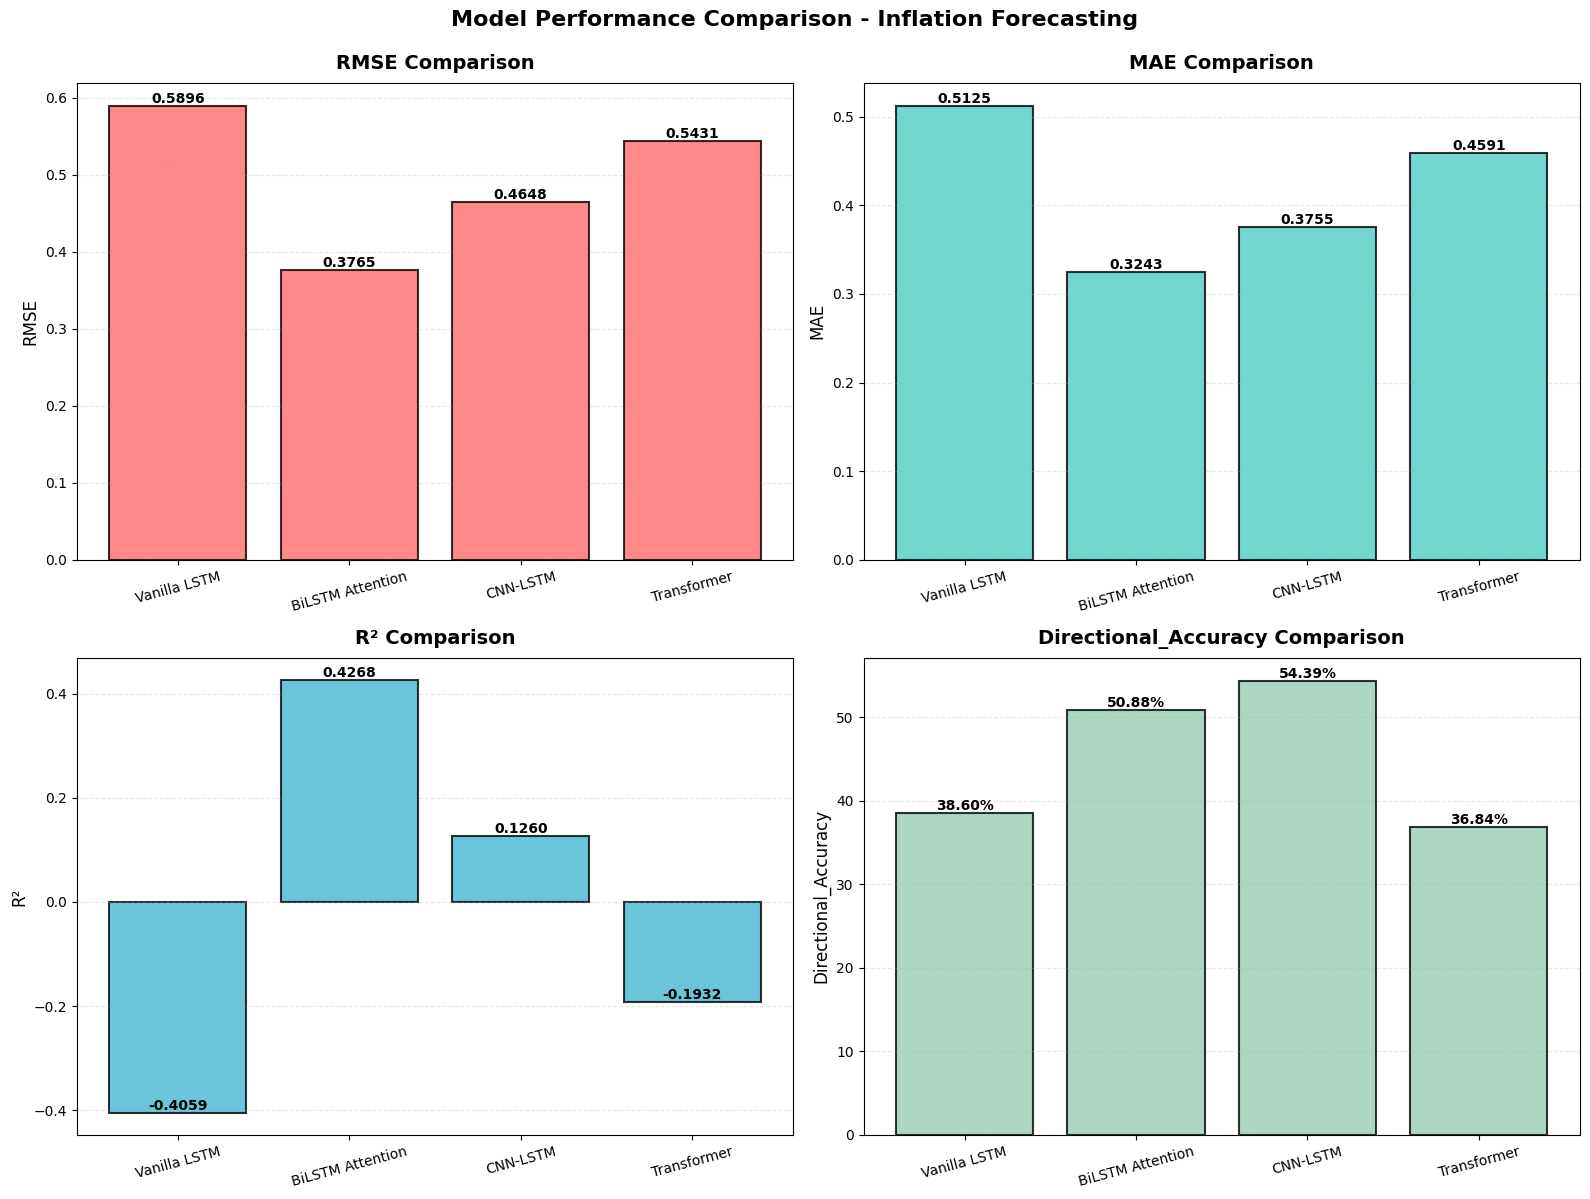

In [15]:
print("\n" + "="*80)
print("FINAL RESULTS: INFLATION FORECASTING")
print("="*80)

results_df_inf = pd.DataFrame(results_inflation).T
print("\n📊 Performance Comparison:")
print(results_df_inf.round(4))

# Save results
results_df_inf.to_csv('/content/inflation_forecasting_results.csv')
print(f"\n✓ Results saved to /content/inflation_forecasting_results.csv")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['RMSE', 'MAE', 'R²', 'Directional_Accuracy']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2

    values = results_df_inf[metric].values
    models = results_df_inf.index

    bars = axes[row, col].bar(models, values, color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=10)
    axes[row, col].set_ylabel(metric, fontsize=12)
    axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
    axes[row, col].tick_params(axis='x', rotation=15)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.4f}' if metric != 'Directional_Accuracy' else f'{height:.2f}%',
                           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Performance Comparison - Inflation Forecasting', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/model_comparison_inflation.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
print("\n" + "="*80)
print("SAVING ARTIFACTS")
print("="*80)

# Save scaler
with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved: /content/scaler.pkl")

# Save feature info
feature_info = {
    'features': core_features,
    'target_inflation_idx': target_inflation_idx,
    'target_oil_idx': target_oil_idx,
    'n_lookback': n_lookback,
    'train_size': train_size,
    'test_size': test_size
}

with open('/content/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("✓ Feature info saved: /content/feature_info.pkl")


SAVING ARTIFACTS
✓ Scaler saved: /content/scaler.pkl
✓ Feature info saved: /content/feature_info.pkl


In [17]:
print("\n" + "="*80)
print("DOWNLOAD FILES")
print("="*80)

print("\n📥 Downloading trained models and results...")

# List all generated files
import os
files_to_download = [
    'vanilla_lstm_inflation_best.keras',
    'bilstm_attention_inflation_best.keras',
    'cnn_lstm_inflation_best.keras',
    'transformer_inflation_best.keras',
    'scaler.pkl',
    'feature_info.pkl',
    'inflation_forecasting_results.csv',
    'correlation_matrix.png',
    'time_series_plots.png',
    'model_comparison_inflation.png'
]

print("\nGenerated Files:")
for i, file in enumerate(files_to_download, 1):
    if os.path.exists(f'/content/{file}'):
        print(f"   {i}. ✓ {file}")
    else:
        print(f"   {i}. ✗ {file} (not found)")

print("\n💡 To download files:")
print("   - Right-click on files in the left sidebar")
print("   - Click 'Download'")
print("   - Or use: files.download('/content/filename')")

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print("\nNext Steps:")
print("1. Download all .keras model files")
print("2. Download scaler.pkl and feature_info.pkl")
print("3. Download results CSV and visualization images")
print("4. Use these files in your Streamlit app")


DOWNLOAD FILES

📥 Downloading trained models and results...

Generated Files:
   1. ✓ vanilla_lstm_inflation_best.keras
   2. ✓ bilstm_attention_inflation_best.keras
   3. ✓ cnn_lstm_inflation_best.keras
   4. ✓ transformer_inflation_best.keras
   5. ✓ scaler.pkl
   6. ✓ feature_info.pkl
   7. ✓ inflation_forecasting_results.csv
   8. ✓ correlation_matrix.png
   9. ✓ time_series_plots.png
   10. ✓ model_comparison_inflation.png

💡 To download files:
   - Right-click on files in the left sidebar
   - Click 'Download'
   - Or use: files.download('/content/filename')

✅ TRAINING COMPLETE!

Next Steps:
1. Download all .keras model files
2. Download scaler.pkl and feature_info.pkl
3. Download results CSV and visualization images
4. Use these files in your Streamlit app
